In [2]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [ ]:
%presentation_style

In [ ]:
%%capture

%set_random_seed 12

In [ ]:
%load_latex_macros

In [12]:
import matplotlib.pyplot as plt
import sbi.analysis
import sbi.inference
import sbi.utils
import torch
import warnings

warnings.filterwarnings("ignore")

# Neural Likelihood and Ratio Estimation

 - Recap of Neural Posterior Estimation 
 - Introduction to Neural Likelihood Estimation (NLE)
 - Exercise 
 - Neural Ratio Estimation (NRE)
 - Pros & Cons of all three methods
  

## Recap: the Goal of SBI

- We want to learn the posterior $p(\theta | \mathbf{x})$ of a model $\mathcal{M}$ given some data $\mathbf{x}$
- We do so using Bayes rule: 
    $$
    p(\theta | \mathbf{x}) = \frac{p(\mathbf{x} | \theta)
    p(\theta)}{p(\mathbf{x})}
    $$
- However, the Likelihood is usually intractable
- We overcome this challenge by sampling from the joint distribution
  $p(\mathbf{x}, \theta)=p(\mathbf{x}\mid \theta)p(\theta)$ and learn a conditional density estimator


## Recap: Neural Posterior Estimation

- Direct mapping from observations $\mathbf{x}$ to posterior $p(\theta|\mathbf{x})$
- E.g. learning Gaussian mixture, parameterized by neural network

## The Likelihood Function

- The Likelihood function is the probability of the data given the model parameters, i.e. $p(\mathbf{x}|\theta)$
- This is a density function in $\mathbf{x}$ for fixed $\theta$

## Learning the Likelihood Function with a Neural Network

- NLE learns $p(\mathbf{x}|\theta)$ instead of $p(\theta|\mathbf{x})$
- Both are conditional density estimation problems ([NB 02](nb_02_conditional_density_estimation.ipynb))
- NLE is a Maximum Likelihood Estimation problem on $\{(\theta, \mathbf{x})_i
  \}^N_{i=1}$ where $\mathcal{M}(\theta_i) = \mathbf{x}_i$
- $\hat{p}(\theta \mid \mathbf{x}) = p(\theta\mid\mathbf{x})p(\theta)$ is a scaled version with constant $frac{1}{p(\mathbf{x})}$ 


## Sampling from the NLE Posterior 

MCMC -> bayes training 


## Why should I use NLE

The goal is to obtain the posterior $p(\theta \mid \mathbf{x})$, why learn
$p(\mathbf{x} \mid \theta)$?

 - Reduced complexity due to factorization for i.i.d. observations 
 - Amortized when increasing the hierarchy 
 - Advantage when $\operatorname{dim}(\theta) \gg \operatorname{dim}(\mathbf{x})$
 - Only the Likelihood is intractable 
 - No correction for sequential learning 

## Quick Intro to the `sbi` Toolkit

- Open Source Software for Simulation-Based Inference; <i class="fa-brands fa-github"></i>[GitHub](https://www.mackelab.org/sbi/)
- Provides SNPE, SNLE and SNRE as well as analysis tools out of the box

In [35]:
# define a uninformative prior
prior = sbi.utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]), high=torch.tensor([1.0, 1.0]) * 2
)


# define a simple simulator
def example_simulator(theta: torch.tensor):
    return torch.sin(theta) + torch.randn_like(theta) * 0.1


# obtain samples from joint distribution
thetas = prior.sample((1_000,))
x = example_simulator(thetas)


# use the first sample as observation
thetas, theta_obs = thetas[1:, :], thetas[0, :]
x, x_obs = x[1:, :], x[0, :]

In [38]:
# obtain a posterior approx. via NPE
inference = sbi.inference.SNPE(prior=prior, density_estimator="maf")
density_estimator = inference.append_simulations(thetas, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 184 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

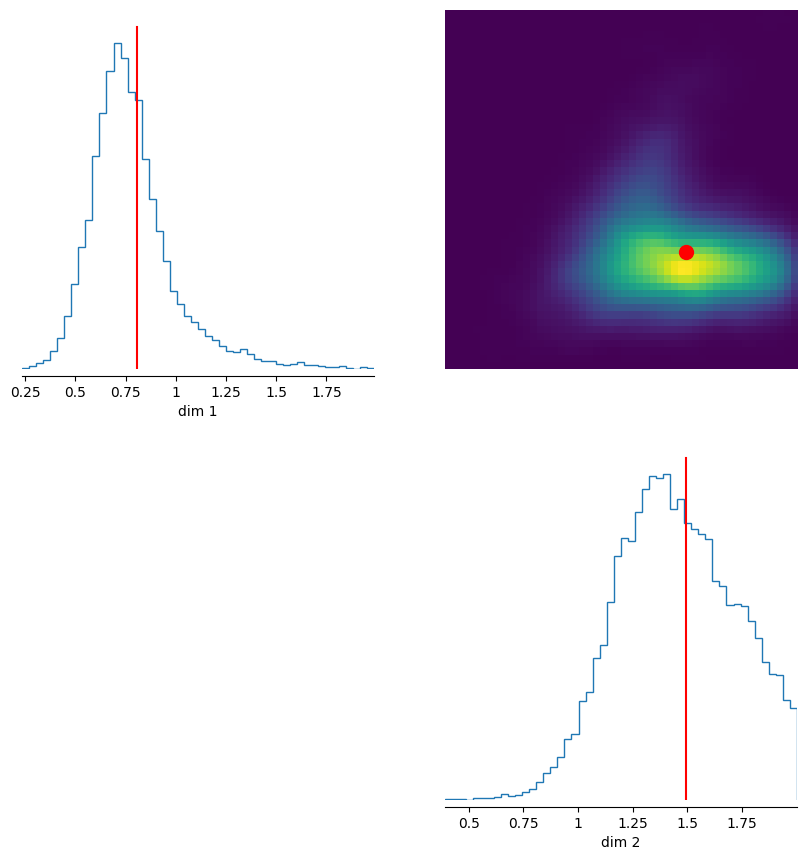

In [60]:
samples = posterior.sample((10_000,), x=x_obs)
_ = sbi.analysis.pairplot(
    samples=samples,
    points=theta_obs,
    points_colors="r",
    upper="kde",
)

## Example: Application of NLE on the SIR Dataset

Same as for NPE


## Neural Ratio Estimation 

one slide; all the info


## Practical Considerations for NPE vs. NLE and NRE

What do we have to keep in mind; when do we prefer which approach


## Summary 

summarize pros and cons for each method

| Method | Pros | Cons |
|:---|:---|:---|
|NPE |... |... |
|NLE |... |... |
|NRE |... |... |


## References

- sbi: A toolkit for simulation-based inference; [GitHub](https://www.mackelab.org/sbi/credits/)

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention!</div>